___
<a href='http://www.pucminas.br/Pos-Graduacao/Paginas/default.aspx'> <img src='assets/puc-logo.png' /></a>
___

## Disciplina : Introdução às Linguagens Estatísticas     
** Professor: Raphael Rodrigues Campos **

** Aluno: Antonio Carneiro de Albuquerque Netto **

** Matrícula: 83026 **
<center><h1>Trabalho Prático</h1></center>

### Imports e header da aplicação

In [168]:
import json
import string
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import groupby

import seaborn as sns
sns.set(color_codes=True)

pandasDF = pd.read_json('perfis.json')
pandasDF.head()

,education,experiences,gender,languages,skills
0,"[{u'date': u'2016 – 2016', u'school': u'Stanfo...","[{u'date': u'set de 2011 – o momento', u'posit...",MALE,"[{u'proficiency': u'Nível avançado', u'name': ...","[{u'endorsement_count': u'+ de 99', u'name': u..."
1,"[{u'date': u'2015 – 2015', u'school': u'Centro...","[{u'date': u'jul de 2017 – o momento', u'posit...",FEMALE,"[{u'name': u'Idioma Inglês'}, {u'name': u'Idio...","[{u'endorsement_count': u'45', u'name': u'Plan..."
2,"[{u'date': u'2016 – 2019', u'school': u'Univer...","[{u'date': u'jul de 2017 – o momento', u'posit...",MALE,"[{u'proficiency': u'Nível avançado', u'name': ...","[{u'endorsement_count': u'8', u'name': u'JavaS..."
3,"[{u'date': u'2014 – 2019', u'school': u'Centro...","[{u'date': u'ago de 2017 – o momento', u'posit...",FEMALE,[{u'proficiency': u'Nível básico a intermediár...,"[{u'endorsement_count': u'2', u'name': u'Net P..."
4,"[{u'date': u'2011 – 2016', u'school': u'Univer...","[{u'date': u'mar de 2017 – o momento', u'posit...",MALE,"[{u'proficiency': u'Fluente ou nativo', u'name...","[{u'endorsement_count': u'13', u'name': u'Micr..."


### Leitura e criação dos DataFrames

**Função Auxiliar para montagem das tabelas e tratamento de valores desnecessários em algumas colunas**

In [169]:
## Func Aux
def setupTable(myColumn):
    
    is_list = myColumn.apply(lambda x: isinstance(x, list))
    only_lists = myColumn[is_list]
    
    ## Tratamento na Languages
    if myColumn.name == 'languages':
        for personLangs in only_lists:
            for lang in personLangs:
                if 'name' in lang:
                    lang['name'] = lang['name'].replace('Idioma\n','')
                    if lang['name'].encode('utf-8').find('Português') != -1 or lang['name'].encode('utf-8').find('Portuguese') != -1 or lang['name'].encode('utf-8').find('Portugais') != -1:
                        lang['name'] = 'PT'
                        lang['idiom_id'] = 0
                    if lang['name'].encode('utf-8').find('Inglês') != -1 or lang['name'].encode('utf-8').find('English') != -1 or lang['name'].encode('utf-8').find('Anglais') != -1:
                        lang['name'] = 'EN'
                        lang['idiom_id'] = 1
                    if lang['name'].encode('utf-8').find('Espanhol') != -1 or lang['name'].encode('utf-8').find('Spanish') != -1:
                        lang['name'] = 'ES'
                        lang['idiom_id'] = 2
                    if lang['name'].encode('utf-8').find('Italiano') != -1 or lang['name'].encode('utf-8').find('Italian') != -1:
                        lang['name'] = 'IT'
                        lang['idiom_id'] = 3
                    if lang['name'].encode('utf-8').find('Francês') != -1 or lang['name'].encode('utf-8').find('French') != -1 or lang['name'].encode('utf-8').find('Français') != -1:
                        lang['name'] = 'FR'
                        lang['idiom_id'] = 4
                    if lang['name'].encode('utf-8').find('Japonês') != -1:
                        lang['name'] = 'JP'
                        lang['idiom_id'] = 5
                    if lang['name'].encode('utf-8').find('Alemão') != -1:
                        lang['name'] = 'GE'
                        lang['idiom_id'] = 6
                    if lang['name'].encode('utf-8').find('Holandês') != -1:
                        lang['name'] = 'NE'
                        lang['idiom_id'] = 7
                    if lang['name'].encode('utf-8').find('Árabe') != -1:
                        lang['name'] = 'AR'
                        lang['idiom_id'] = 8
                    
                if 'proficiency' in lang:
                    proficiency = lang['proficiency'].encode('utf-8')
                    lang['proficiency'] = proficiency.replace('N\xc3\xadvel ','')
    
    ## Tratamento na Education
    uniqueSchools = pd.unique(eduDF[['school']].values.ravel())
    if myColumn.name == 'education':
        for personEducation in only_lists:
            for eduItem in personEducation:
                ## Removendo parte desnecessária da string degree e major
                if 'degree' in eduItem:
                    degreeName = eduItem['degree'].replace('Nome do diploma\n','')
                    eduItem['degree'] = degreeName
                if 'major' in eduItem:
                    majorName = eduItem['major'].encode('utf-8').replace('Área de estudo\n','')
                    eduItem['major'] = majorName
                if 'school' in eduItem:
                    for sIdx, school in enumerate(uniqueSchools):
                        if eduItem['school'] == school:
                            eduItem['school_id'] = sIdx
    
    if myColumn.name == 'skills':
        for personSkill in only_lists:
            for skillItem in personSkill:
                if 'endorsement_count' in skillItem:
                    if skillItem['endorsement_count'].encode('utf-8').find('+ de 99') != -1:
                        skillItem['endorsement_count'] = 99
    #return only_lists[0]
    df = pd.DataFrame.from_dict(only_lists.sum())
    df['personId'] = np.repeat(only_lists.index,
                                   only_lists.apply(lambda x: len(x)))
    return df

### Tabela de Languages

In [119]:
## LANG table
langDF = setupTable(pandasDF.languages)
langDF

,idiom_id,name,proficiency,personId
0,2.0,ES,avançado,0
1,1.0,EN,Fluente ou nativo,0
2,0.0,PT,Fluente ou nativo,0
3,1.0,EN,NaN,1
4,3.0,IT,NaN,1
5,1.0,EN,avançado,2
6,0.0,PT,Fluente ou nativo,2
7,2.0,ES,básico a intermediário,3
8,1.0,EN,avançado,3
9,0.0,PT,Fluente ou nativo,3


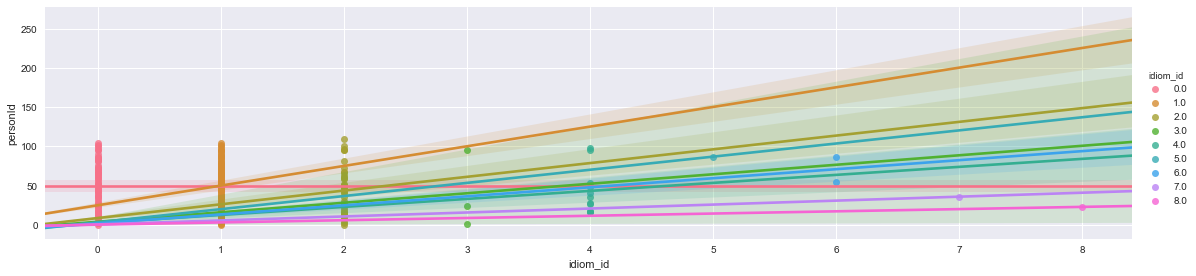

In [92]:
# Idiom per Person linear relationships
sns.lmplot(x='idiom_id', y='personId', data=langDF, fit_reg=True,size=4, aspect=4,hue="idiom_id")

In [85]:
totalPersonsForLang = langDF.groupby('name')['personId'].agg(['count'])
totalPersonsForLang

,count
name,
AR,1
EN,85
ES,39
FR,11
GE,2
IT,3
JP,1
LIBRAS,1
NE,1


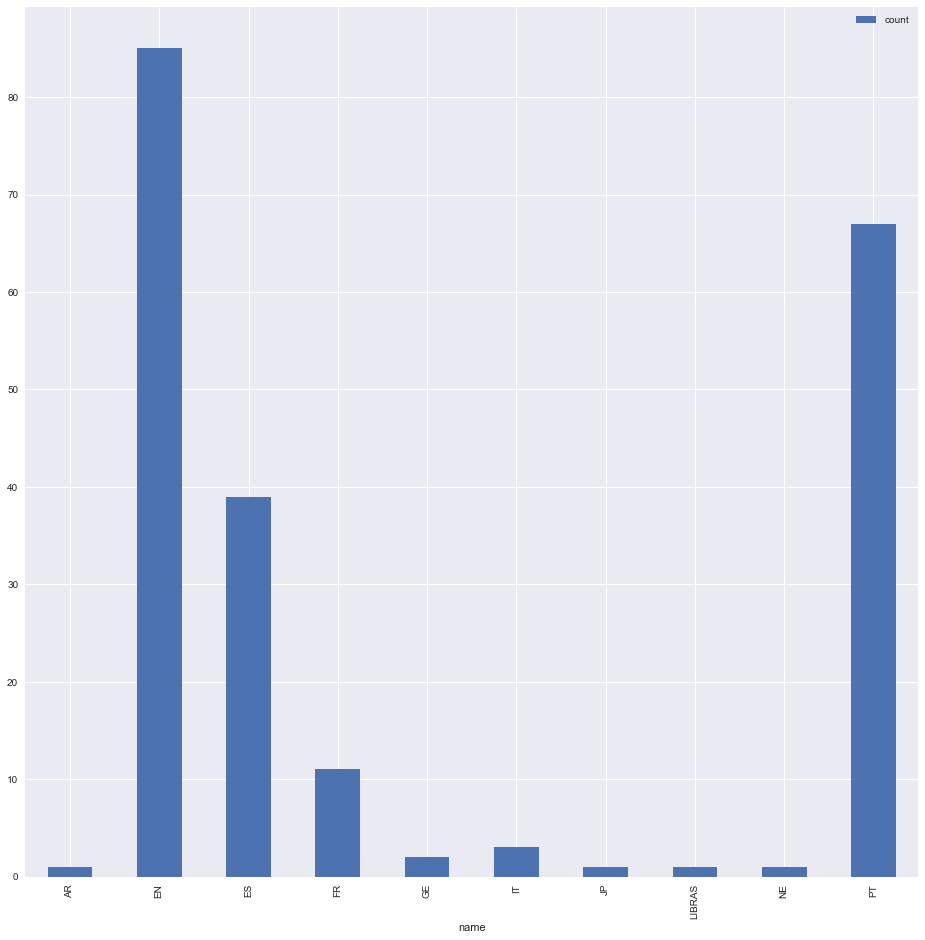

In [94]:
%matplotlib inline
totalPersonsForLang.plot(kind='bar',figsize=(16, 16))

### Tabela de Experiences

In [95]:
## EXP table
expDF = setupTable(pandasDF.experiences)
expDF

,company,date,location,position,personId
0,Trojan Technologies,set de 2011 – o momento,"Belo Horizonte e Região, Brasil",CEO and Founder,0
1,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,0
5,NaN,NaN,NaN,NaN,0
6,Any Company,mar de 2016 – o momento,NaN,Endeavor Entrepreneur,0
7,Any Company,out de 2015 – o momento,"Belo Horizonte e Região, Brasil",Investor and Board Member,0
8,Any Company,out de 2012 – mai de 2013,"Santiago, Chile",Start-Up Chile Entrepreneur,0
9,Any Company,set de 2009 – jan de 2011,"São Paulo e Região, Brasil",Founder and Sales Director,0


In [97]:
totalPersonsInPosition = expDF.groupby('position')['personId'].agg(['count'])
totalPersonsInPosition

,count
position,
Account Executive,1
Account Manager,1
Administrador de clínica médica,1
Advisor to the Presidency,1
Agente Censitário Municipal,1
Agente Comercial,1
Aluno do projeto Bepid,1
Analista Comercial,1
Analista Desenvolvedor,1


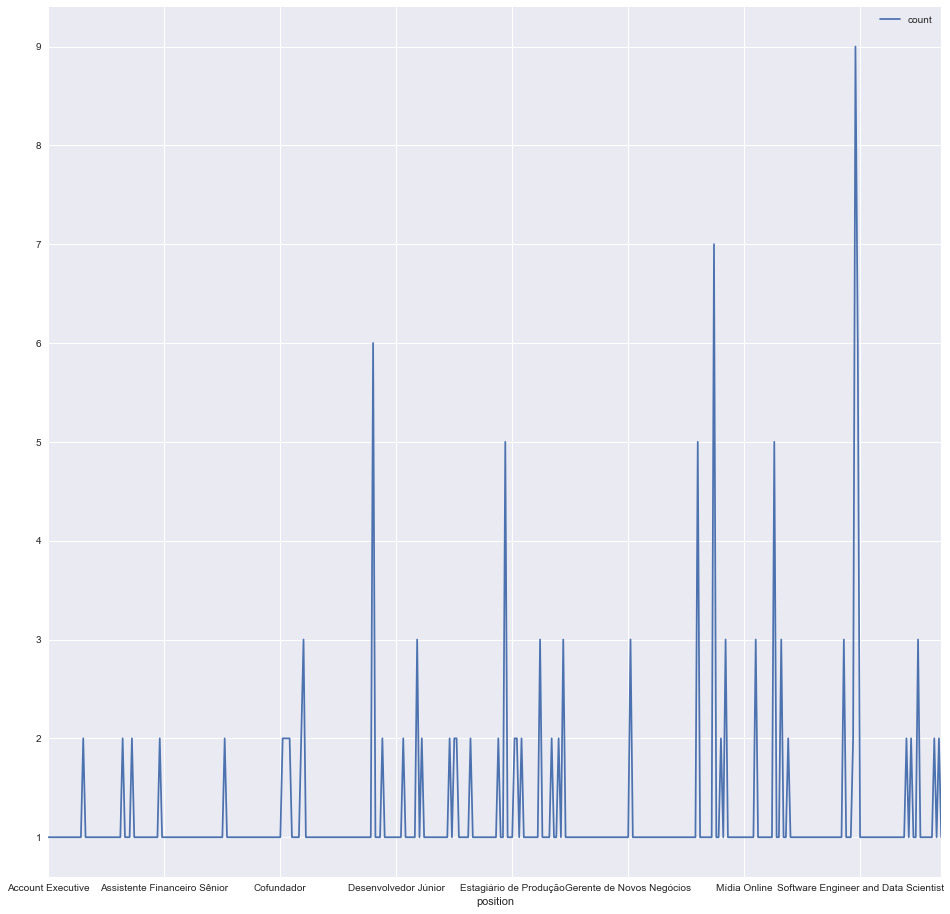

In [99]:
%matplotlib inline
totalPersonsInPosition.plot(kind='line',figsize=(16, 16))

In [100]:
totalPersonsPerLocation = expDF.groupby('location')['personId'].agg(['count'])
totalPersonsPerLocation

,count
location,
,1
1 Bootcamp Gama Academy - Belo Horizonte,1
"Alphaville-Barueri,SP",1
Alphaville-Barueri-SP,1
Alvorada,1
"Amesterdã e Região, Holanda",1
"Aulnoye-Aymeries, France",1
"Av. Brasil, Nº 2971 - Compensa - Cep – 69036-110",1
"Av. Efigênio Salles, 1155 - Aleixo, Manaus - AM, 69057-050",1


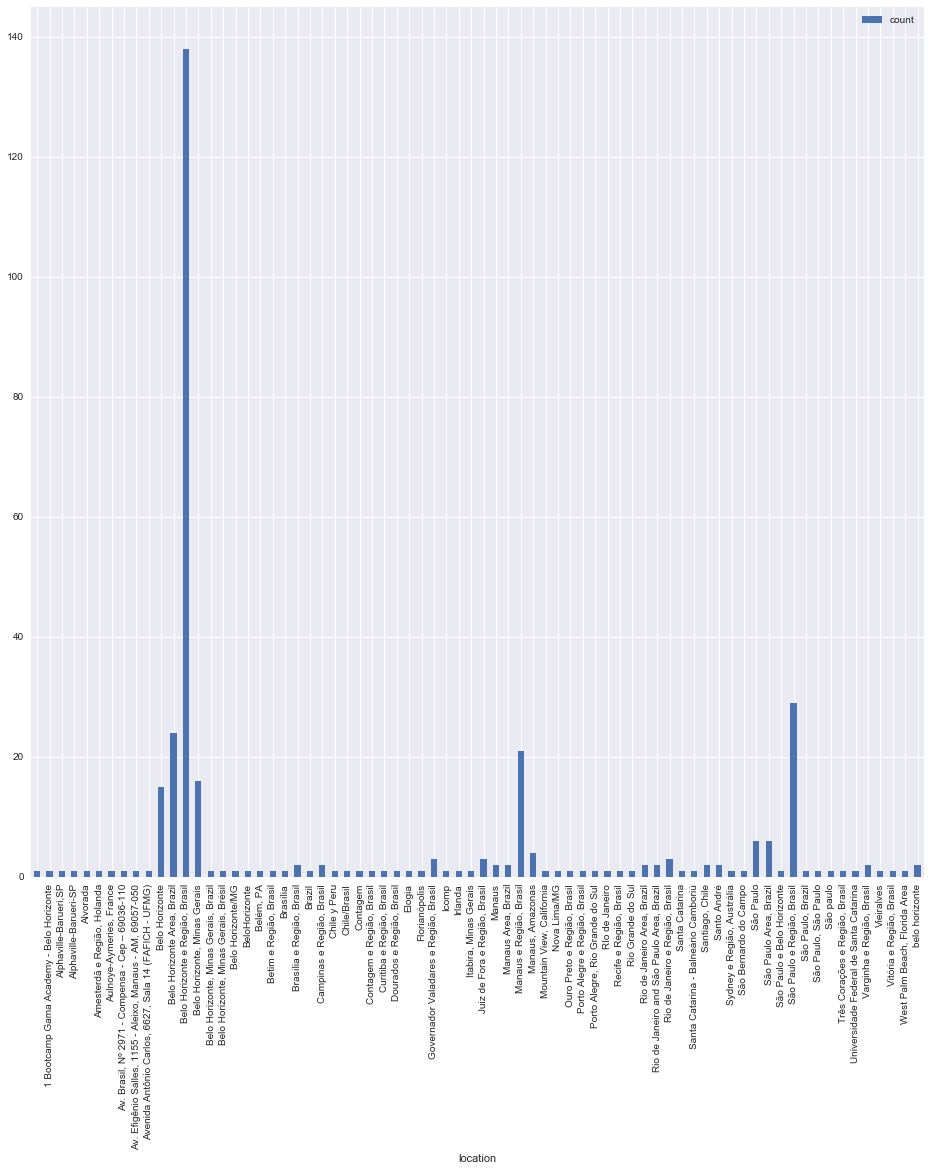

In [101]:
%matplotlib inline
totalPersonsPerLocation.plot(kind='bar',figsize=(16, 16))

### Tabela de Skills

In [124]:
## Skills table
skillDF = setupTable(pandasDF.skills)
skillDF

,endorsement_count,name,personId
0,99,Empresas startups,0
1,NaN,NaN,0
2,NaN,NaN,0
3,99,Empreendedorismo,0
4,NaN,NaN,0
5,NaN,NaN,0
6,97,Start-ups,0
7,NaN,NaN,0
8,NaN,NaN,0
9,73,Entrepreneurship,0


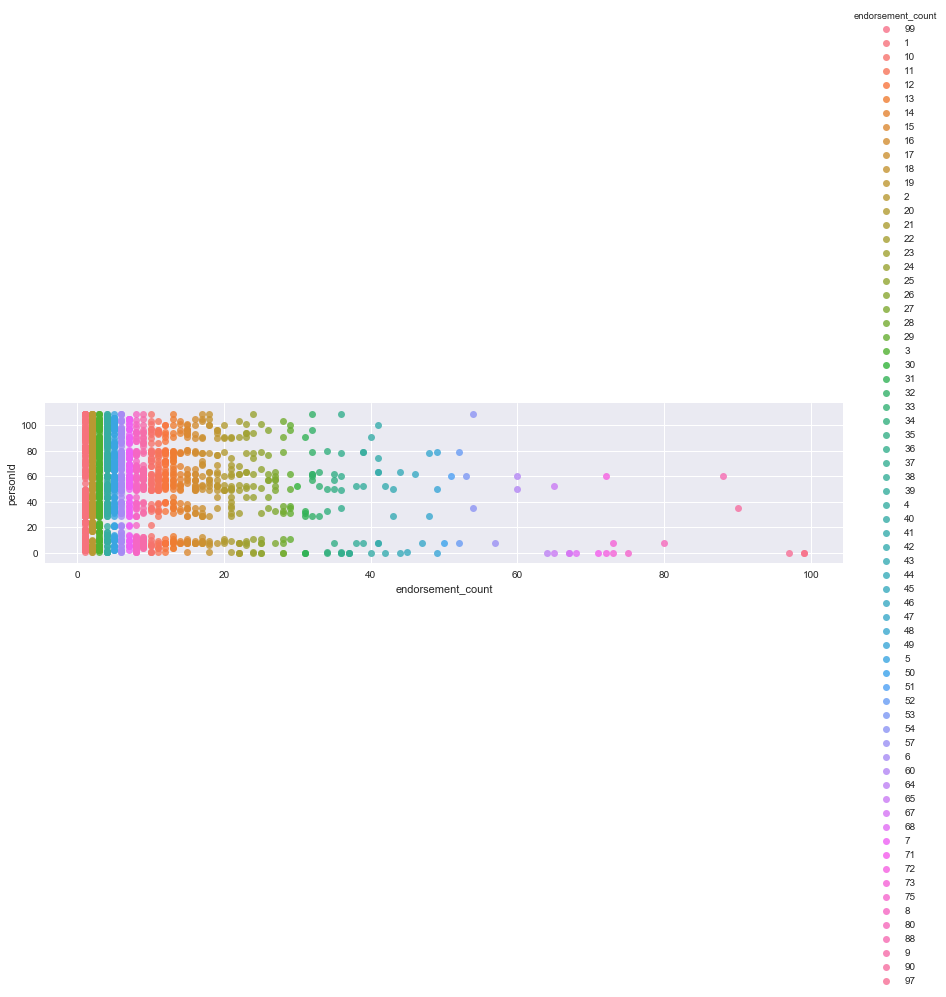

In [132]:
# Endorsement per Person linear relationships
sns.lmplot(x='endorsement_count', y='personId', data=skillDF, fit_reg=False,size=3, aspect=4, hue='endorsement_count')

In [134]:
totalPersonsPerSkill = skillDF.groupby('name')['personId'].agg(['count'])
totalPersonsPerSkill

,count
name,
.NET,1
.NET Framework,1
5S,1
A/B Testing,1
AJAX,4
AMP,1
ASP.NET,1
AWS,1
Accessibility,2


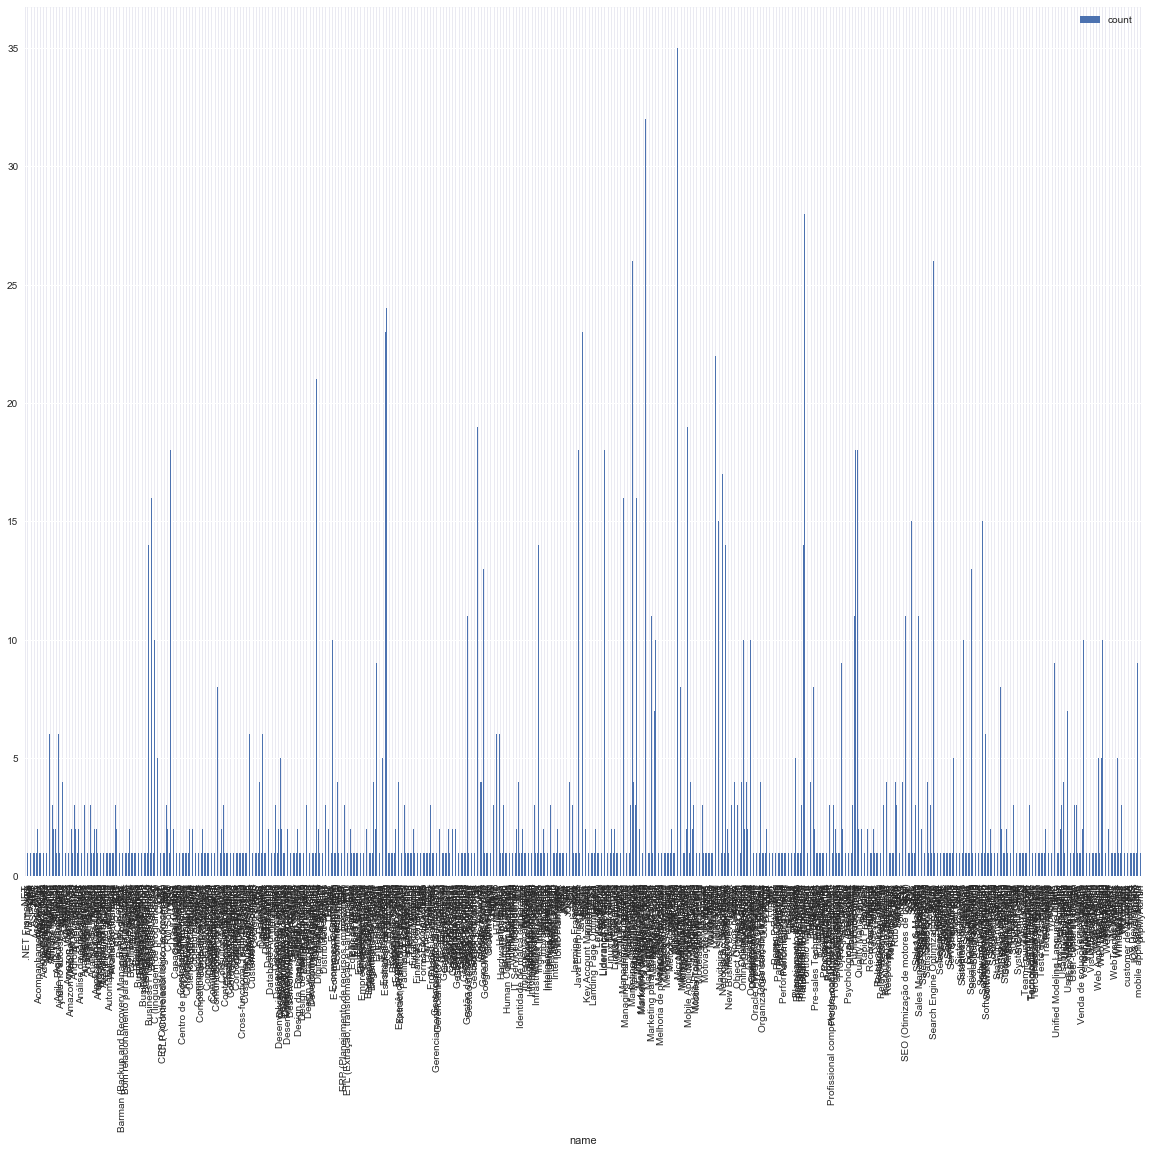

In [136]:
%matplotlib inline
totalPersonsPerSkill.plot(kind='bar',figsize=(20,16))

### Tabela de Education

In [170]:
## Education table
eduDF = setupTable(pandasDF.education)
eduDF

,date,degree,major,school,school_id,personId
0,2016 – 2016,"Executive Education, Innovation & Entrepreneur...",NaN,Stanford University,0.0,0
1,2007 – 2010,Economics,Economics,Universidade Federal de Minas Gerais,1.0,0
2,2015 – 2015,Master of Business Administration (MBA),Gestão de Negócios,Centro Universitário Newton Paiva,2.0,1
3,2009 – 2012,Bacharel em Design de Ambientes,Design de Interiores,Universidade do Estado de Minas Gerais,3.0,1
4,2016 – 2019,Bachelor’s Degree,Computer Technology/Computer Systems Technology,Universidade Federal de Minas Gerais,1.0,2
5,2013 – 2015,Technician,"Informatics, COLTEC",Universidade Federal de Minas Gerais,1.0,2
6,2014 – 2019,Engenharia de Produção Civil,NaN,Centro Federal de Educação Tecnológica de Mina...,4.0,3
7,2011 – 2016,Bachelor of Science (B.S.),Chemical Engineering,Universidade Federal de Minas Gerais,1.0,4
8,2015 – 2015,Bachelor of Science (B.S.),Chemical Engineering,California State University-Long Beach,5.0,4
9,2011 – 2011,Pós Graduação em Gestão Estratégica de Negócios,Economia e Gestão Empresarial,Universidade FUMEC,6.0,5


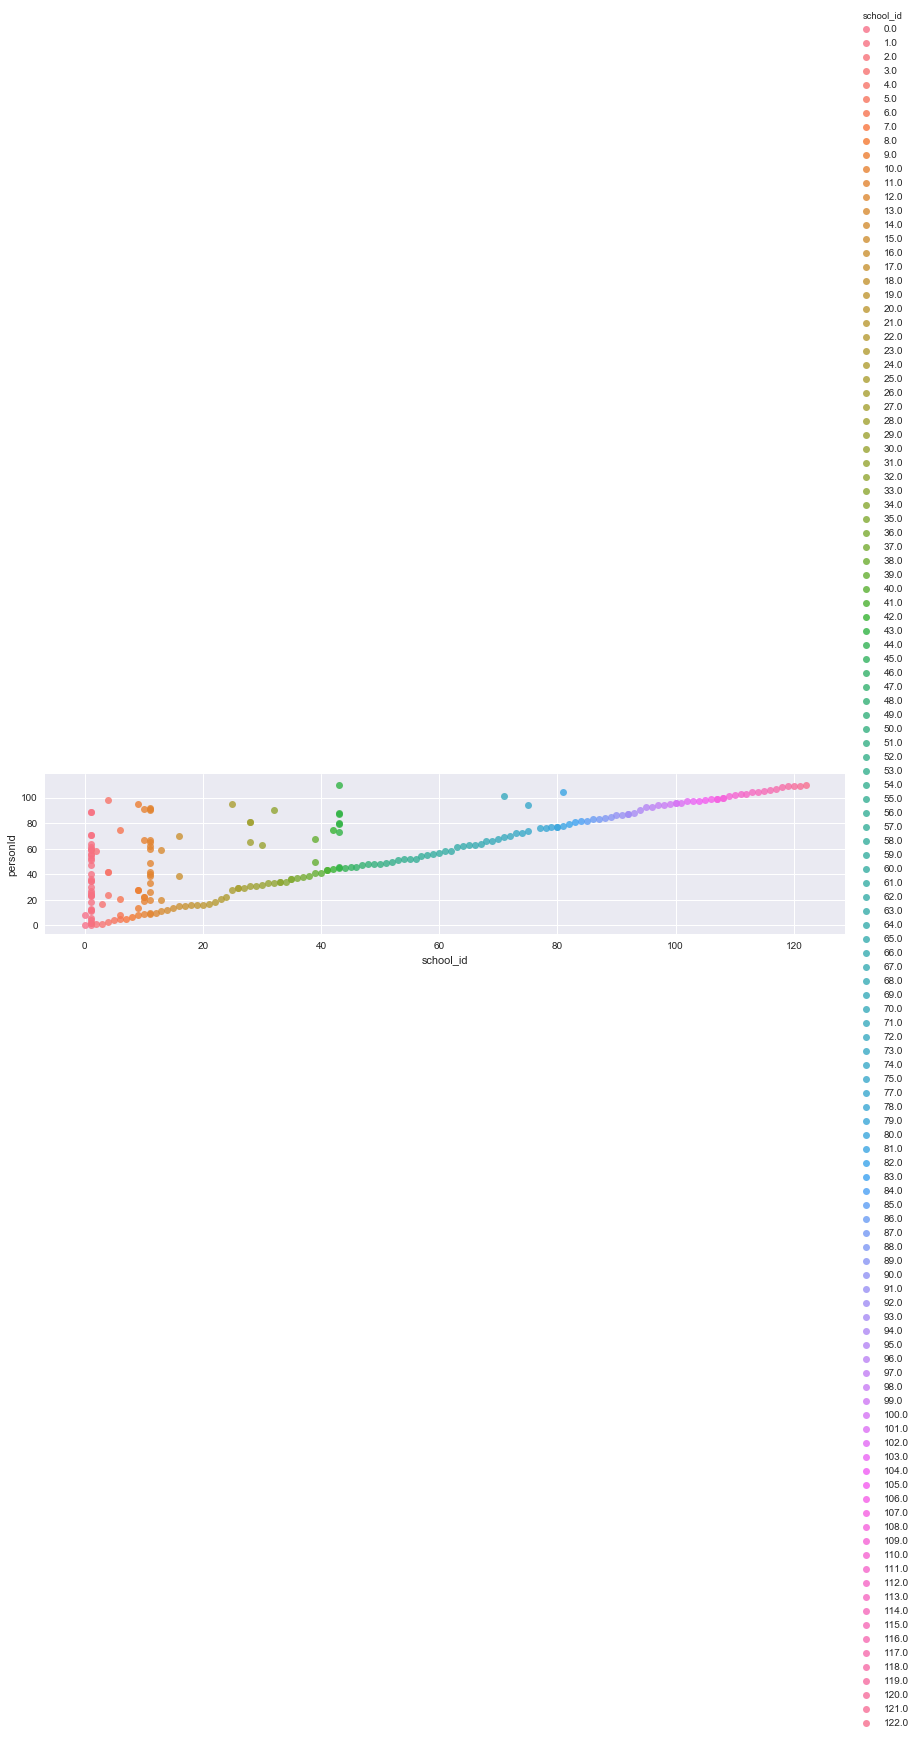

In [173]:
# School per Person linear relationships
sns.lmplot(x='school_id', y='personId', data=eduDF, fit_reg=False,size=3, aspect=4, hue='school_id')

In [174]:
totalPersonsPerSchool = eduDF.groupby('school')['personId'].agg(['count'])
totalPersonsPerSchool

,count
school,
Academia Internacional de Cinema,1
Amazonas State University - UEA,1
Anhanguera Educacional,1
Bridge Business College,1
Business Training Company,1
COTEMIG,1
CSA | Colégio Santo Antônio,1
Caldwell Community College and Technical Institute,1
California State University-Long Beach,1


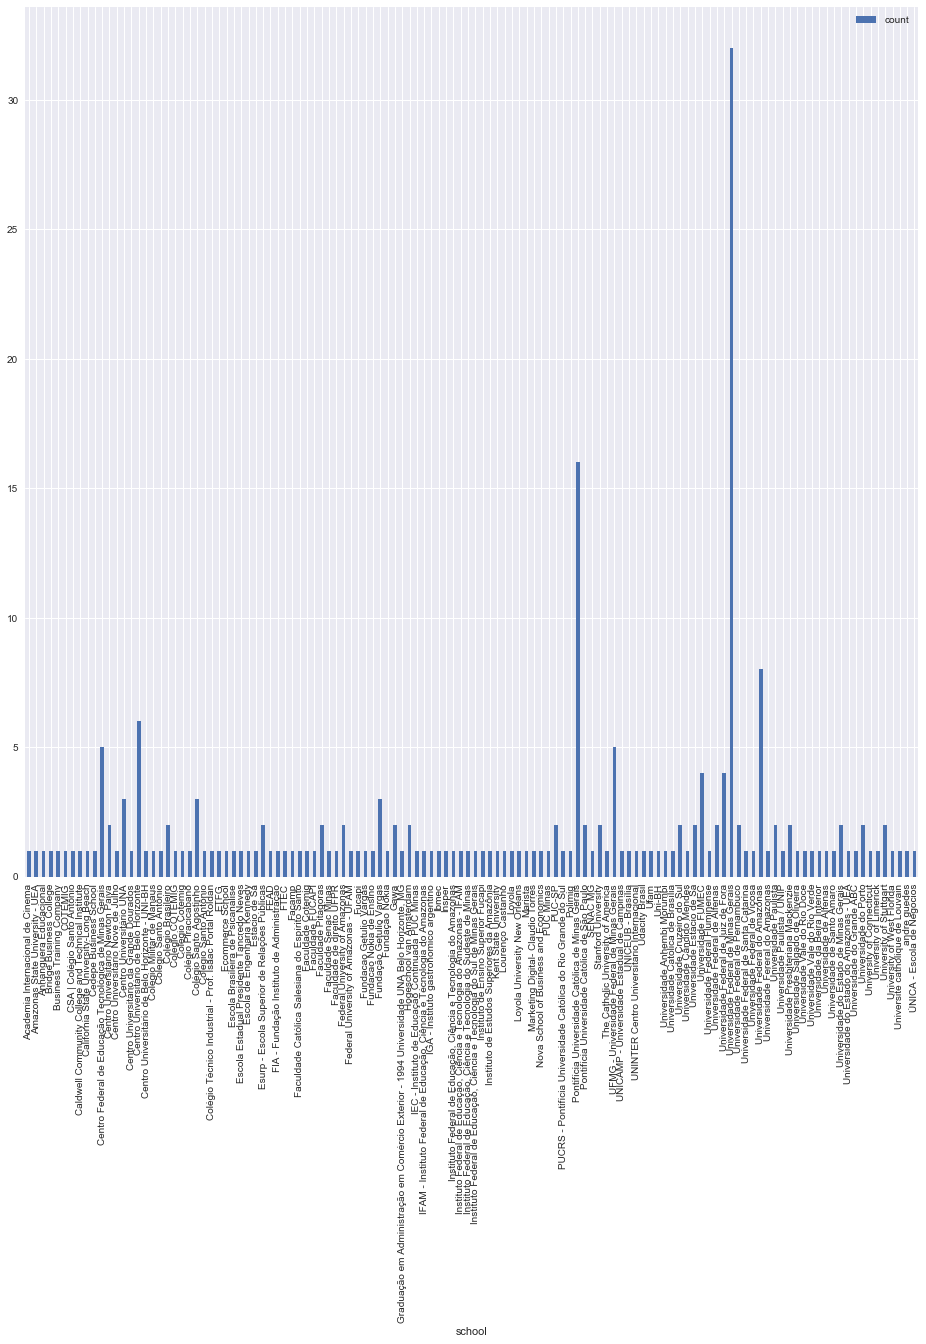

In [175]:
%matplotlib inline
totalPersonsPerSchool.plot(kind='bar',figsize=(16,16))

In [176]:
totalPersonsPerDegree = eduDF.groupby('degree')['personId'].agg(['count'])
totalPersonsPerDegree

,count
degree,
2011,1
Administracao de Empresas,1
Administração em Comércio Exterior,1
Analise Google Analytics,1
Analise e Desenvolvimento de Sistemas,1
Analista de Sistemas,1
B.S. in Computer Science,1
Bacharel,6
Bacharel - Publicidade e Propaganda,1


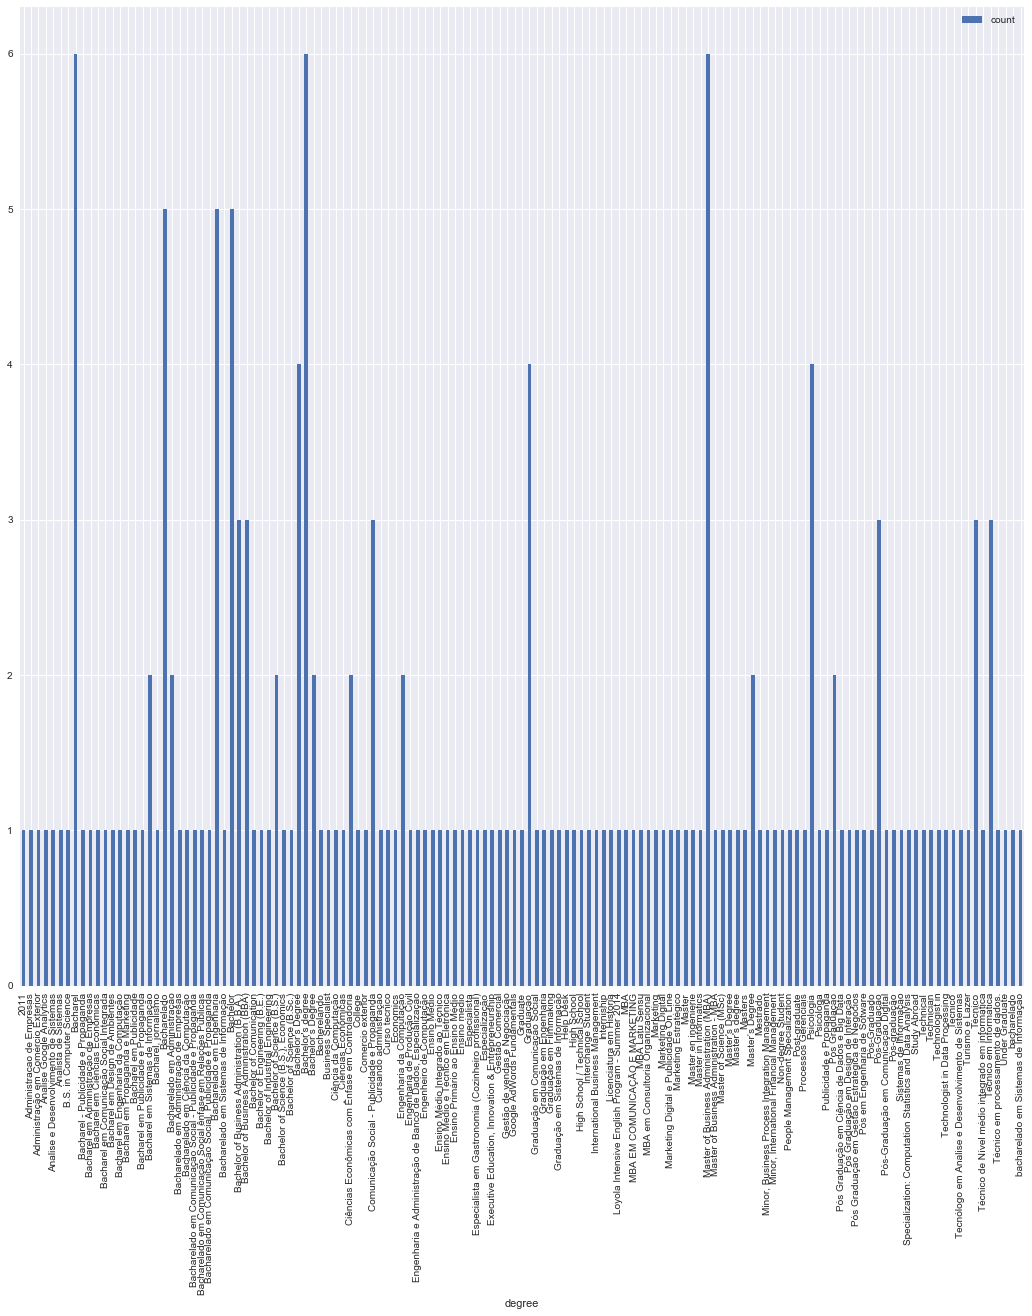

In [178]:
%matplotlib inline
totalPersonsPerDegree.plot(kind='bar', figsize=(18,18))